# Example: Gaussian Mixture

2020-11-29 first uploaded

In [185]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import itertools
from flow import *
from utils import *
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
print(tf.__version__)
!python --version

2.3.0
Python 3.6.9


## Settings

In [186]:
n_means = 8
radius = 14
sd = 1
labels = ['red','gold','green','chocolate','blue','magenta','pink','purple']
# labels = ['red','red','red','red','blue','blue','green','purple']
assert len(labels) == n_means

x_dim = 2
y_dim = len(list(set(labels)))
z_dim = 2
tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim
n_sample = 200
n_data = n_sample * n_means
n_couple_layer = 3
n_hid_layer = 3
n_hid_dim = 512

n_batch = 200
n_epoch = 1000
n_display = 100

(8, 200, 2)


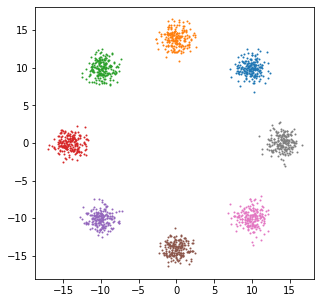

In [187]:
# Make data
X_raw = np.zeros((n_means, n_sample, x_dim), dtype='float32')
for i in range(n_means):
    th = 2*np.pi / n_means * (i+1)
    mean = [radius*np.cos(th), radius*np.sin(th)]
    X_raw[i, :, :] = np.random.multivariate_normal(mean, np.identity(x_dim)*sd, size=n_sample)

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')
for i in range(n_means):
    ax.scatter(X_raw[i,:,0], X_raw[i,:,1], s=1)
print(X_raw.shape)

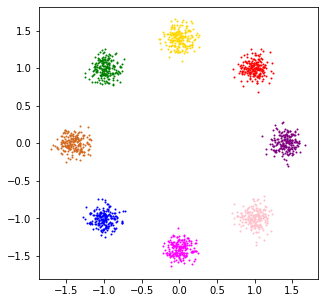

In [188]:
# Preprocess
uq_labels = list(set(labels))
idx2lab = {i:lab for i, lab in enumerate(uq_labels)}
lab2idx = {idx2lab[key]:i for i, key in enumerate(idx2lab.keys())}

X = X_raw.reshape((-1, x_dim))
X = StandardScaler().fit_transform(X)
y = [[lab2idx[lab]]*n_sample for lab in labels]
y = list(itertools.chain.from_iterable(y)) # flatten
y_onehot = np.eye(len(uq_labels))[y].astype('int')

fig, ax = plt.subplots(figsize=(5,5), facecolor='white')
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y]
    ax.scatter(X[idx,0], X[idx,1], s=1, c=color)

In [189]:
# Pad data
pad_x = np.zeros((X.shape[0], pad_dim))
x_data = np.concatenate([X, pad_x], axis=-1).astype('float32')
z = np.random.multivariate_normal([0.]*x_dim, np.eye(x_dim), X.shape[0])
y_data = np.concatenate([z, y_onehot], axis=-1).astype('float32')

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x_data)
y_data = tf.data.Dataset.from_tensor_slices(y_data)
dataset = (tf.data.Dataset.zip((x_data, y_data))
           .shuffle(buffer_size=X.shape[0])
           .batch(n_batch, drop_remainder=True)
           .repeat())

## Initialize the model

In [190]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name='NVP')
x = tfk.Input((tot_dim,))
model(x);
model.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer0 (TwoNVPCouplingLayers (None, 10)                1067038   
_________________________________________________________________
Layer1 (TwoNVPCouplingLayers (None, 10)                1067038   
_________________________________________________________________
Layer2 (TwoNVPCouplingLayers (None, 10)                1067038   
Total params: 3,201,114
Trainable params: 3,201,084
Non-trainable params: 30
_________________________________________________________________


In [193]:
class Trainer(tfk.Model):
    def __init__(self, model, x_dim, y_dim, z_dim, tot_dim, 
                 n_couple_layer, n_hid_layer, n_hid_dim, shuffle_type='reverse'):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = 5.
        self.w2 = 1.
        self.w3 = 10.
        self.loss_factor = 1.
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, :self.x_dim]
        y = y_data[:, -self.y_dim:]
        z = y_data[:, :self.z_dim]
        y_short = tf.concat([z, y], axis=-1)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)    
            pred_loss = self.w1 * self.loss_fit(y_data[:,self.z_dim:], y_out[:,self.z_dim:]) # [zeros, y] <=> [zeros, yhat]
            output_block_grad = tf.concat([y_out[:,:self.z_dim], y_out[:, -self.y_dim:]], axis=-1) # take out [z, y] only (not zeros)
            latent_loss = self.w2 * self.loss_latent(y_short, output_block_grad) # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_backward, self.model.trainable_weights)) 

        total_loss = forward_loss + latent_loss + rev_loss
        return {'total_loss': total_loss,
                'forward_loss': forward_loss,
                'latent_loss': latent_loss,
                'rev_loss': rev_loss}

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [194]:
trainer = Trainer(model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim)
trainer.compile(optimizer='Adam')

## Train the model

In [195]:
%%time
LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)
hist = trainer.fit(dataset,
                   batch_size=n_batch,
                   epochs=n_epoch,
                   steps_per_epoch=n_data//n_batch, 
                   callbacks=[logger, LossFactor], 
                   verbose=0)

=== Started at 2020-11-30 03h:06m:06s ===
 2020-11-30 03h:06m:09s | Epoch: 0001/1000 | total_loss=0.988495 forward_loss=0.424852 latent_loss=0.183585 rev_loss=0.380058
 2020-11-30 03h:06m:16s | Epoch: 0100/1000 | total_loss=0.107274 forward_loss=0.045898 latent_loss=0.037941 rev_loss=0.023435
 2020-11-30 03h:06m:24s | Epoch: 0200/1000 | total_loss=0.081464 forward_loss=0.031639 latent_loss=0.028787 rev_loss=0.021038
 2020-11-30 03h:06m:31s | Epoch: 0300/1000 | total_loss=0.083621 forward_loss=0.034332 latent_loss=0.031991 rev_loss=0.017298
 2020-11-30 03h:06m:39s | Epoch: 0400/1000 | total_loss=0.074498 forward_loss=0.031239 latent_loss=0.029693 rev_loss=0.013566
 2020-11-30 03h:06m:47s | Epoch: 0500/1000 | total_loss=0.065678 forward_loss=0.026799 latent_loss=0.025322 rev_loss=0.013558
 2020-11-30 03h:06m:54s | Epoch: 0600/1000 | total_loss=0.075266 forward_loss=0.033230 latent_loss=0.031321 rev_loss=0.010715
 2020-11-30 03h:07m:01s | Epoch: 0700/1000 | total_loss=0.068402 forward_los

## Check results

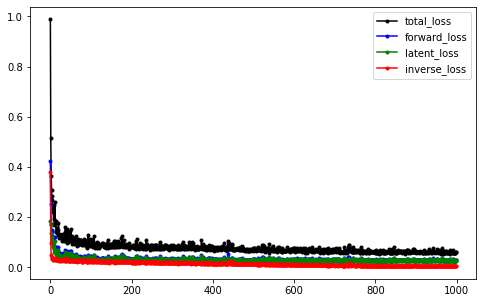

In [196]:
fig, ax = plt.subplots(1, facecolor='white', figsize=(8,5))
ax.plot(hist.history['total_loss'], 'k.-', label='total_loss')
ax.plot(hist.history['forward_loss'], 'b.-', label='forward_loss')
ax.plot(hist.history['latent_loss'], 'g.-', label='latent_loss')
ax.plot(hist.history['rev_loss'], 'r.-', label='inverse_loss')
plt.legend()

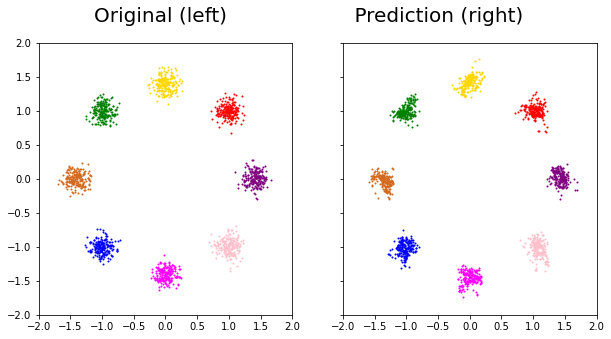

In [221]:
z = np.random.multivariate_normal([1.]*z_dim, np.eye(z_dim), y_onehot.shape[0])
y = np.concatenate([z, y_onehot], axis=-1).astype('float32')
x_pred = model.inverse(y).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), facecolor='white', sharex=True, sharey=True)
for i, color in zip(idx2lab.keys(), lab2idx.keys()):
    idx = [True if j==i else False for j in y_onehot.argmax(axis=-1)]
    ax1.scatter(X[idx,0], X[idx,1], s=1, c=color)
    ax2.scatter(x_pred[idx,0], x_pred[idx,1], s=1, c=color)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([-2, 2])
plt.suptitle('Original (left)                    Prediction (right)', fontsize=20);